<a href="https://colab.research.google.com/github/NandhiniP1408/model-comparison-project/blob/main/Netflix_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rows, Columns: (8807, 12)

Type counts:
 type
Movie      6131
TV Show    2676
Name: count, dtype: int64


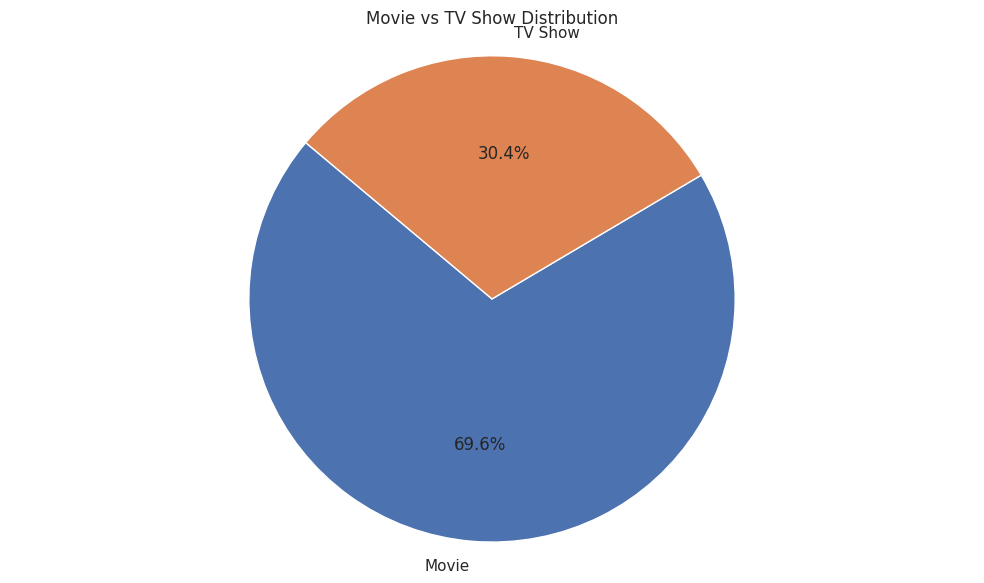

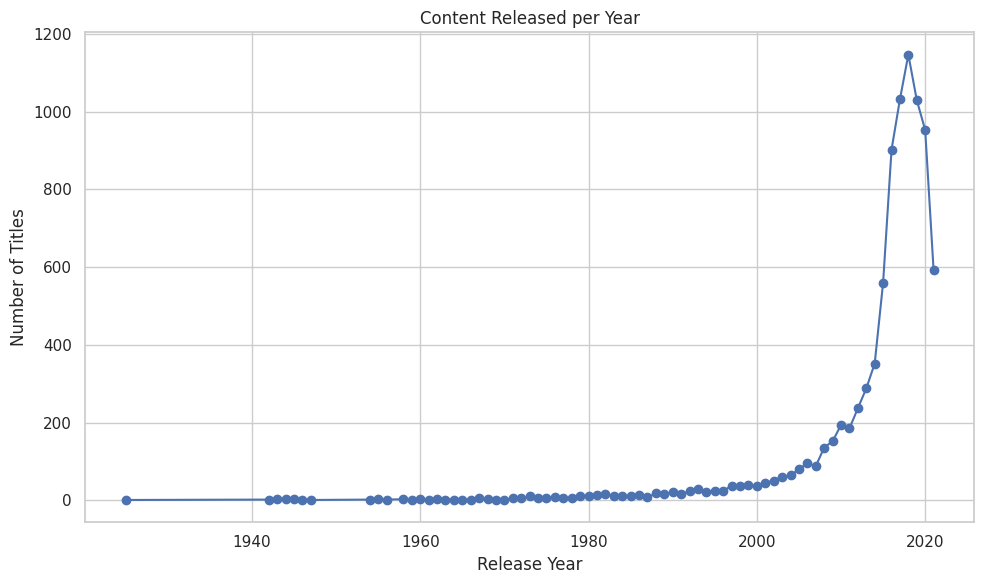

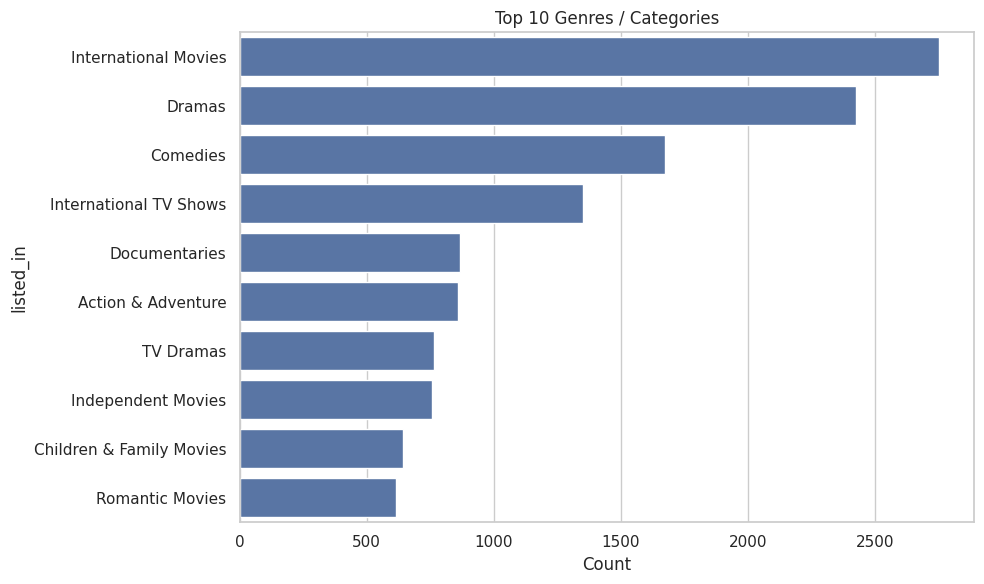

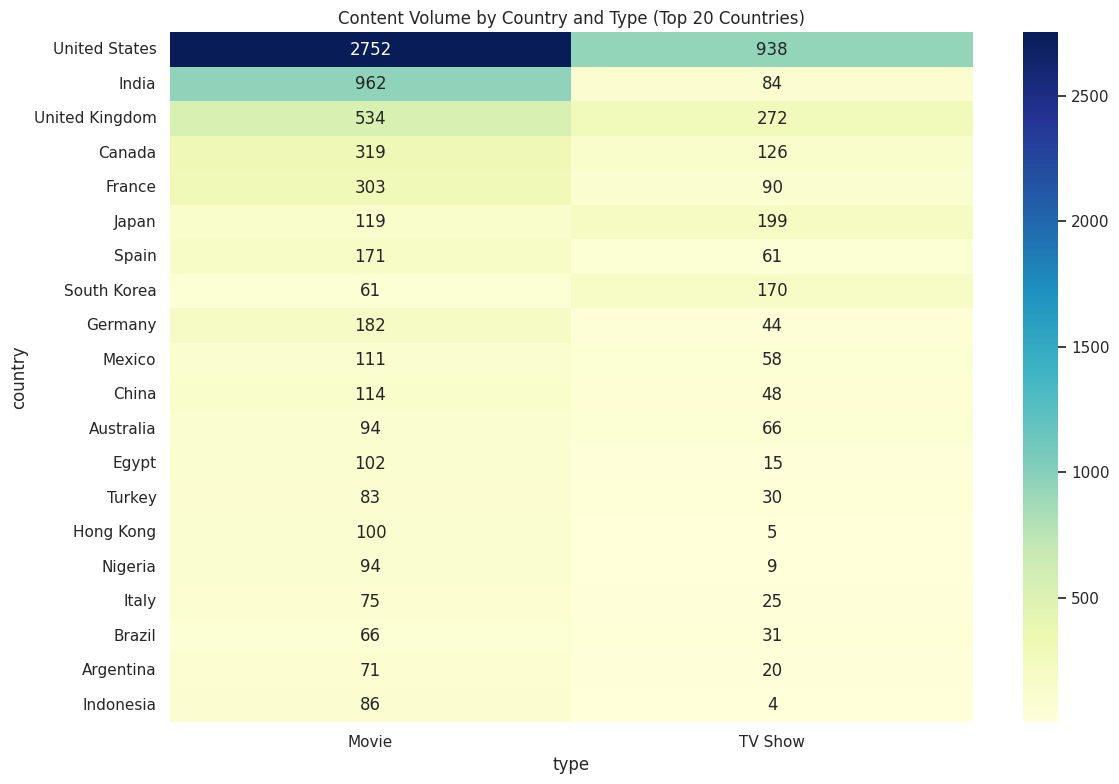

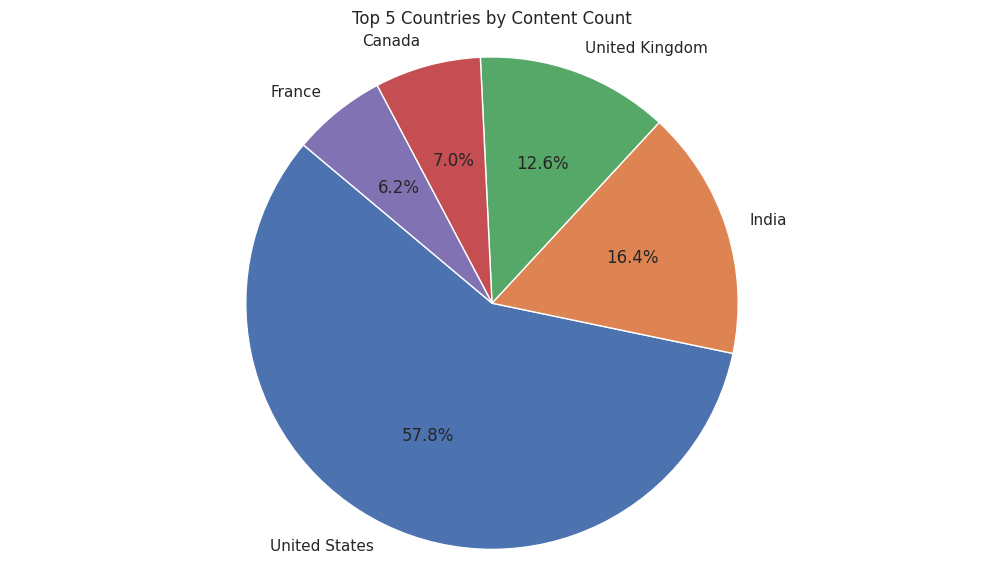

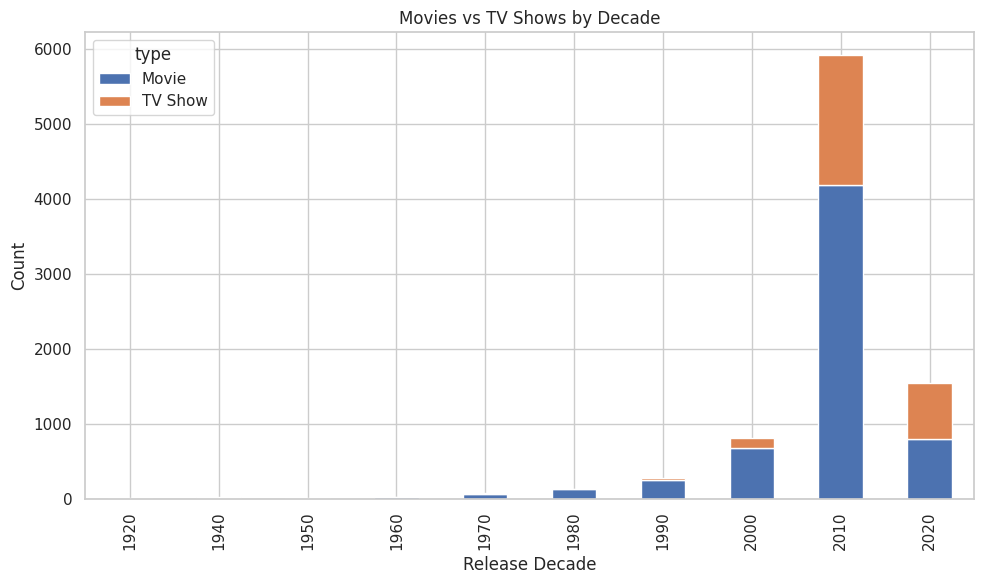


=== Insights (automatically generated) ===
Most common content type: Movie (6131 titles)
Linear trend: approx. 6.88 titles/year (positive slope indicates growth).
Top 5 producing countries (by number of titles): United States, India, United Kingdom, Canada, France
Top genres/categories: International Movies, Dramas, Comedies, International TV Shows, Documentaries

Forecast (naive linear) for next 2 years:
   year  predicted_titles
0  2022               383
1  2023               390

Example summary (paste into report):

Between 1925 and 2021, content volumes changed as shown above. Most common content type: Movie (6131 titles). Linear trend: approx. 6.88 titles/year (positive slope indicates growth). Top genres include: International Movies, Dramas, Comedies, International TV Shows, Documentaries. Top producing countries include: United States, India, United Kingdom, Canada, France.


In [2]:
# Netflix Titles Dataset — Exploratory Analysis & Insights
# Notebook style Python script (use with Jupyter / VSCode - Run cells separated by '# %%')

# %% [markdown]
# Task 4: Netflix Titles Dataset — Exploratory Analysis & Insights
# Objective: Explore media content data and identify viewing trends, content types, and popular countries.

# %%
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import os

# set plotting style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10,6)

# %% [markdown]
# 2. Load dataset
# Replace the path below with the path to your downloaded CSV file (netflix_titles.csv)
CSV_PATH = 'Netflix Dataset.csv'  # <-- change this if needed

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at {CSV_PATH}. Please download the Netflix Titles dataset from Kaggle and set CSV_PATH accordingly.")

df = pd.read_csv(CSV_PATH)

# Quick peek
print('Rows, Columns:', df.shape)
df.head()

# %% [markdown]
# 3. Data understanding & cleaning
# Convert date_added to datetime, handle missing director/cast, extract features

# %%
# a) Convert date_added
if 'date_added' in df.columns:
    df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

# b) Fill missing director / cast
for col in ['director', 'cast']:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

# c) is_movie feature
if 'type' in df.columns:
    df['is_movie'] = df['type'].str.strip().str.lower() == 'movie'

# d) release_year (some datasets already have it)
if 'release_year' not in df.columns and 'date_added' in df.columns:
    df['release_year'] = df['date_added'].dt.year

# e) release_decade
if 'release_year' in df.columns:
    df['release_decade'] = (df['release_year'] // 10 * 10).astype('Int64')

# f) ensure listed_in exists (genres)
if 'listed_in' not in df.columns:
    df['listed_in'] = ''

# %% [markdown]
# 4. Feature engineering: split multi-label columns (country, genres)

# Helper to split, normalize and explode
def explode_multi_label_column(df, col, sep=','):
    s = df[col].fillna('').astype(str).str.split(sep)
    s = s.apply(lambda x: [item.strip() for item in x if item and item.strip()])
    exploded = df.loc[s.index].assign(**{col: s}).explode(col)
    exploded = exploded[exploded[col].notna() & (exploded[col] != '')]
    return exploded

# Countries exploded
if 'country' in df.columns:
    countries_exploded = explode_multi_label_column(df, 'country', sep=',')
else:
    countries_exploded = pd.DataFrame()

# Genres exploded
genres_exploded = explode_multi_label_column(df, 'listed_in', sep=',')

# %% [markdown]
# 5. Quick aggregated counts

# Movie vs TV shows
type_counts = df['type'].value_counts(dropna=False)
print('\nType counts:\n', type_counts)

# Content per release_year
year_counts = df['release_year'].value_counts().sort_index()

# Top genres
top_genres = genres_exploded['listed_in'].value_counts().head(20)

# Top countries
if not countries_exploded.empty:
    top_countries = countries_exploded['country'].value_counts().head(20)
else:
    top_countries = pd.Series(dtype=int)

# %% [markdown]
# 6. Visualizations (save figures into ./figures)
os.makedirs('figures', exist_ok=True)

# Pie chart: Movie vs TV shows
# %%
plt.figure()
labels = type_counts.index.tolist()
sizes = type_counts.values
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Movie vs TV Show Distribution')
plt.axis('equal')
plt.tight_layout()
plt.savefig('figures/movie_vs_tv_pie.png', dpi=150)
plt.show()

# Line plot: Content released per year (use release_year)
# %%
plt.figure()
# Filter reasonable years (remove NaN or extreme)
year_counts_clean = year_counts[year_counts.index.notna()]
# optionally remove zeros or very old
year_counts_clean.loc[~year_counts_clean.index.isnull()].plot(marker='o')
plt.xlabel('Release Year')
plt.ylabel('Number of Titles')
plt.title('Content Released per Year')
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/content_per_year.png', dpi=150)
plt.show()

# Barplot: Top 10 genres
# %%
plt.figure()
sns.barplot(x=top_genres.head(10).values, y=top_genres.head(10).index)
plt.xlabel('Count')
plt.title('Top 10 Genres / Categories')
plt.tight_layout()
plt.savefig('figures/top_genres_bar.png', dpi=150)
plt.show()

# Heatmap: Country vs content volume (top 20 countries x type)
# %%
if not countries_exploded.empty:
    country_type = countries_exploded.groupby(['country','type']).size().unstack(fill_value=0)
    top20 = country_type.sum(axis=1).sort_values(ascending=False).head(20).index
    mat = country_type.loc[top20]
    plt.figure(figsize=(12,8))
    sns.heatmap(mat, annot=True, fmt='d', cmap='YlGnBu')
    plt.title('Content Volume by Country and Type (Top 20 Countries)')
    plt.tight_layout()
    plt.savefig('figures/country_type_heatmap.png', dpi=150)
    plt.show()

# Additional visualization: Top 5 countries pie
# %%
if not countries_exploded.empty:
    pcs = countries_exploded['country'].value_counts().head(5)
    plt.figure()
    plt.pie(pcs.values, labels=pcs.index, autopct='%1.1f%%', startangle=140)
    plt.title('Top 5 Countries by Content Count')
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig('figures/top5_countries_pie.png', dpi=150)
    plt.show()

# Stacked bar: Movies vs TV Shows per decade
# %%
if 'release_decade' in df.columns and 'type' in df.columns:
    dec_type = df.groupby(['release_decade','type']).size().unstack(fill_value=0)
    dec_type = dec_type.sort_index()
    dec_type.plot(kind='bar', stacked=True)
    plt.xlabel('Release Decade')
    plt.ylabel('Count')
    plt.title('Movies vs TV Shows by Decade')
    plt.tight_layout()
    plt.savefig('figures/decade_stacked_bar.png', dpi=150)
    plt.show()

# %% [markdown]
# 7. Insights & Interpretations
# We'll compute a few straightforward insights programmatically and then summarise them.

# Insight 1: Most common content type
most_common_type = type_counts.idxmax()
ins1 = f"Most common content type: {most_common_type} ({type_counts.max()} titles)"

# Insight 2: Growth trend (yearly)
# Compute CAGR / trend using linear regression on year_counts
# Prepare data for regression (drop NaNs, years with 0 if needed)
valid_years = year_counts_clean.dropna()
if len(valid_years) >= 5:
    X = valid_years.index.values.reshape(-1,1)
    y = valid_years.values
    # Fit simple linear regression
    lr = LinearRegression()
    lr.fit(X, y)
    y_pred = lr.predict(X)
    slope = lr.coef_[0]
    ins2 = f"Linear trend: approx. {slope:.2f} titles/year (positive slope indicates growth)."
else:
    ins2 = 'Not enough reliable year data to compute a trend.'

# Insight 3: Top countries
if not top_countries.empty:
    top5_countries = top_countries.head(5).index.tolist()
    ins3 = f"Top 5 producing countries (by number of titles): {', '.join(top5_countries)}"
else:
    ins3 = 'Country data not available or empty.'

# Insight 4: Popular genres
top5_genres = top_genres.head(5).index.tolist()
ins4 = f"Top genres/categories: {', '.join(top5_genres)}"

# print insights
print('\n=== Insights (automatically generated) ===')
print(ins1)
print(ins2)
print(ins3)
print(ins4)

# %% [markdown]
# 8. "What does this mean?" interpretation (template text for report)
# - If Movies dominate: Netflix (or the dataset) contains more feature-length content than TV shows. This may indicate licensing or content acquisition focus.
# - If there's increasing titles/year: content production/licensing is expanding — more choice for viewers, but discoverability becomes harder.
# - Top genres & countries tell you where content sourcing is strongest; useful for localization and marketing.

# %% [markdown]
# 9. Bonus: Trend prediction for next 2 years (simple linear extrapolation)

# We'll predict total titles released per year (release_year) using linear regression
# Note: this is a naive forecast — it assumes linear growth. Mention in report that more advanced methods (ARIMA, Prophet) may improve forecasts.

# %%
forecast_results = None
if len(valid_years) >= 5:
    X = valid_years.index.values.reshape(-1,1)
    y = valid_years.values
    lr = LinearRegression()
    lr.fit(X, y)
    last_year = int(X.max())
    future_years = np.array([last_year+1, last_year+2]).reshape(-1,1)
    preds = lr.predict(future_years).round().astype(int)
    forecast_results = pd.DataFrame({'year': future_years.flatten(), 'predicted_titles': preds})
    print('\nForecast (naive linear) for next 2 years:')
    print(forecast_results)
else:
    print('\nNot enough data to produce a forecast (need at least 5 years).')

# %% [markdown]
# 10. Deliverables checklist (what this notebook produces):
# - Python notebook (this script cell-separated for Jupyter)
# - 5+ visuals saved in ./figures
# - Insight summary printed above and can be copy-pasted to a report
# - Bonus: simple 2-year trend prediction (linear)

# %% [markdown]
# 11. Suggestions to extend / improve the project
# - Use time-series models (ARIMA / SARIMA / Prophet) for better forecasting.
# - Perform language analysis on titles/descriptions to find topical trends.
# - Use collaborative filtering / popularity signals to rank content per country.
# - Perform year-by-year genre dynamics (which genres grew/shrank).

# %% [markdown]
# 12. Example short Insight Summary (copy into report)
# "Between YEAR_MIN and YEAR_MAX, the dataset shows X% more titles per year on average. Movies/TV split is A/B indicating ... Top genres are G1, G2,... Top producing countries are C1, C2,... This suggests ..."

min_year = int(valid_years.index.min()) if not valid_years.empty else 'N/A'
max_year = int(valid_years.index.max()) if not valid_years.empty else 'N/A'
example_summary = f"Between {min_year} and {max_year}, content volumes changed as shown above. {ins1}. {ins2} Top genres include: {', '.join(top5_genres)}. Top producing countries include: {', '.join(top5_countries) if not top_countries.empty else 'N/A'}."

print('\nExample summary (paste into report):\n')
print(example_summary)

# End of notebook
